In [24]:
import re
import warnings
warnings.filterwarnings('ignore')

from ulteis import preprocess, vectorize

import gensim
import matplotlib.pyplot as plt
import pandas as pd
import pyLDAvis
import pyLDAvis.gensim
import seaborn as sns
from gensim import corpora
from gensim.models import CoherenceModel, LdaModel, LsiModel, Nmf
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, confusion_matrix, f1_score,
                             precision_score, recall_score)
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

In [6]:
# Lendo o dataset e separando os dados e as classes

bbc_df = pd.read_csv("../data/bbc_data.csv")

#bbc_df["labels"] = bbc_df["labels"].map({"entertainment": 0, "tech": 1, "business": 2, "politics": 3, "sport": 4})

X_train, X_test, y_train, y_test = train_test_split(bbc_df["data"], bbc_df["labels"], test_size=0.30, random_state=42)

bbc_df.head()

,data,labels
0,Musicians to tackle US red tape Musicians gro...,entertainment
1,"U2s desire to be number one U2, who have won ...",entertainment
2,Rocker Doherty in on-stage fight Rock singer ...,entertainment
3,Snicket tops US box office chart The film ada...,entertainment
4,"Oceans Twelve raids box office Oceans Twelve,...",entertainment


## Para essa etapa fica a escolha a opção de lematizar ou stimizar, em parcular como iremos trabalhar com modelagem de topico mais a fente é mais adaquado para faciliatar a analize lematizar

In [22]:
# Preprocessamento

X_train = X_train.apply(preprocess)
X_test = X_test.apply(preprocess)

# Usaremos mais a frente para modelar topicos
texts_topics = [word.split() for word in X_train] 

print(X_train[22], '\n')
print(X_test[29], '\n')

producer scoop stage award producer beaten mary poppins battle blockbuster west end musical olivier award producer three prize uk prestigious annual theatre award mary poppins two mel brook hit show triumphed battle best new musical mary poppins andrew lloyd webbers woman white alan bennett history boy big winner straight theatre category picking three trophy eye musical prize producer mary poppins woman white high profile opening last six month producer nathan lane last minute replacement richard dreyfus beat former co star lee evans win best musical actor lane already left production smash hit broadway moving london show also best musical performance supporting role conleth hill play director roger debris mary poppins award came best choreography best musical actress star laura michelle kelly led nomination going sunday ceremony london hilton hotel nine award show stage adaptation film history boy set grammar school early partly based bennett experience teacher named best new play al

In [8]:
# Vectors Bag of words
cv = CountVectorizer()
cv_df, cv_df_test = vectorize(cv,X_train, X_test)

# Vectors TF-IDF
tfidf = TfidfVectorizer()
tfidf_df, tfidf_df_test = vectorize(tfidf,X_train, X_test)



In [ ]:
# Metrics analysis

def metrics_describe(model, df_test):
    y_pred = model.predict(df_test)
    
    #metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="weighted")
    recall = recall_score(y_test, y_pred, average="weighted")
    f1 = f1_score(y_test, y_pred, average="weighted")
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    #plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [3, 1]})
    
    classes = model.classes_
    
    # Plotar a matriz de confusão no primeiro subplot
    sns.heatmap(conf_matrix, annot=True, cmap="YlGnBu", fmt="d", cbar=False, ax=ax1,xticklabels=classes, yticklabels=classes)
    ax1.set_title('Matriz de Confusão')
    ax1.set_xlabel('Classe Prevista')
    ax1.set_ylabel('Classe Verdadeira')

    # Escrever as métricas no segundo subplot
    ax2.axis('off')  # Esconde os eixos
    metrics_text = f"""Métricas:
    Accuracy:  {accuracy:.2f}
    Precision: {precision:.2f}
    Recall:    {recall:.2f}
    F1 Score:  {f1:.2f}"""

    ax2.text(0.5, 0.5, metrics_text, fontsize=14, ha='center', va='center', bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))
    plt.show()

## O seguintes resultados são referentes a vetorização com Bang of Words

In [10]:
# modelos utilizados
clf = LogisticRegression()
svm = LinearSVC()
nb = MultinomialNB()

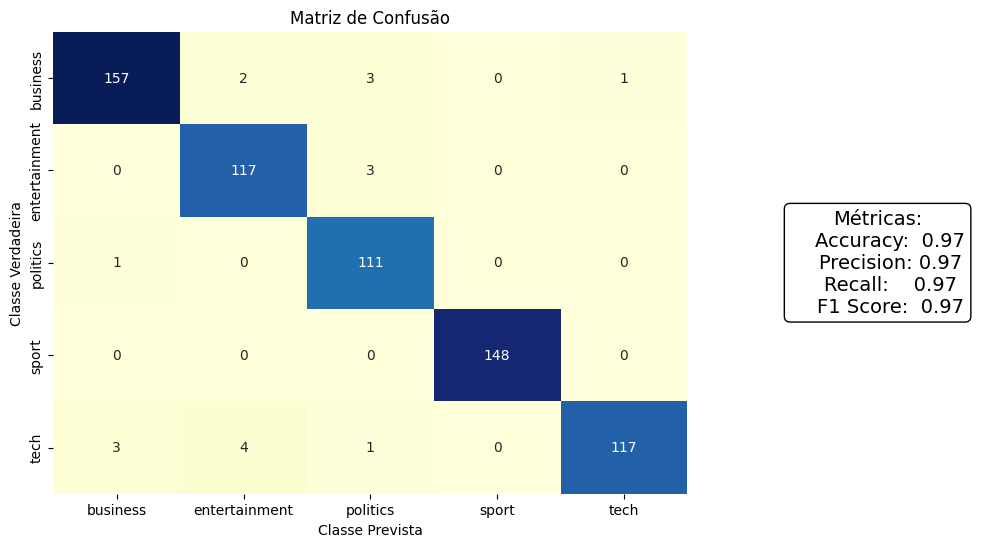

In [11]:
# Logistic Regression

clf.fit(cv_df, y_train)
metrics_describe(clf, cv_df_test)

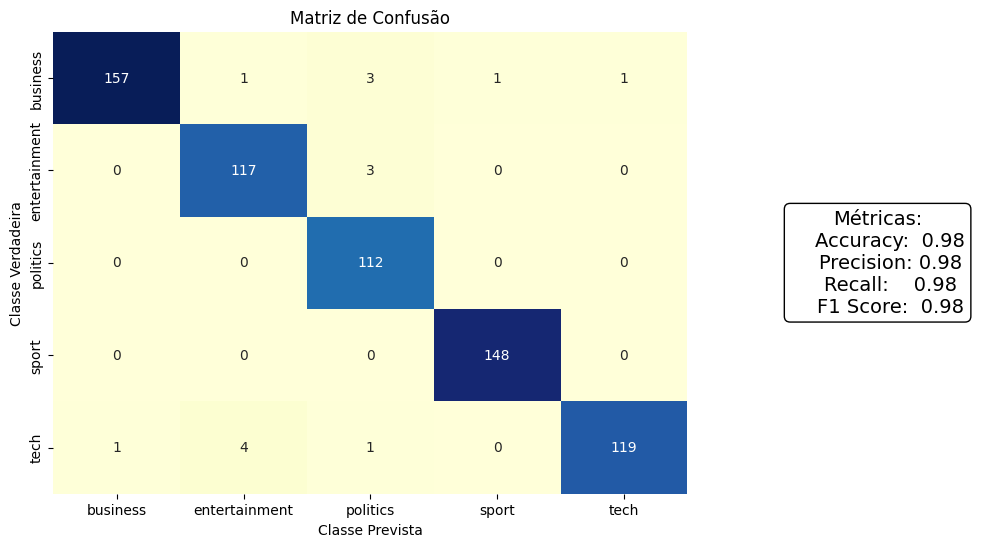

In [12]:
svm.fit(cv_df, y_train)
metrics_describe(svm, cv_df_test)

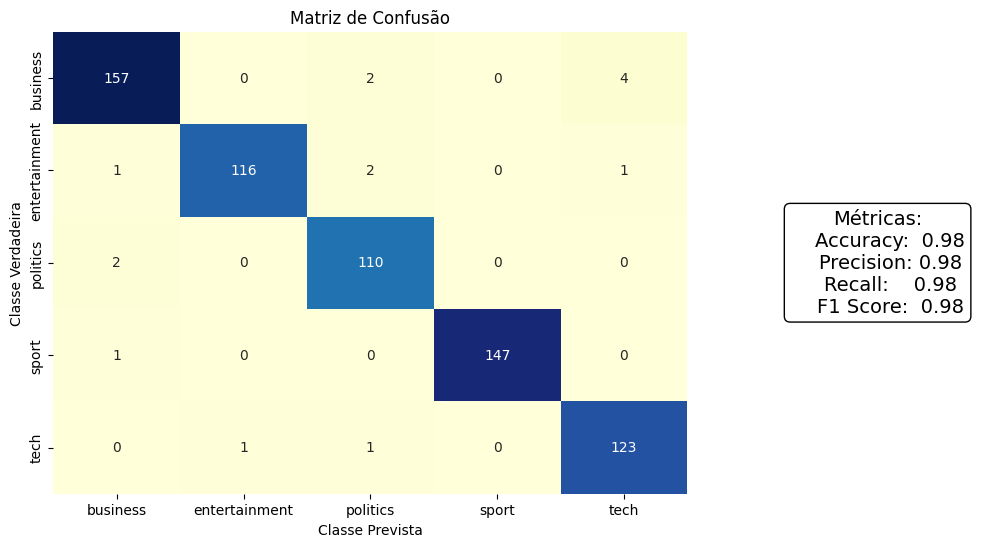

In [13]:
nb.fit(cv_df, y_train)
metrics_describe(nb, cv_df_test)

## O seguintes resultados são referentes a vetorização com TF-IDF

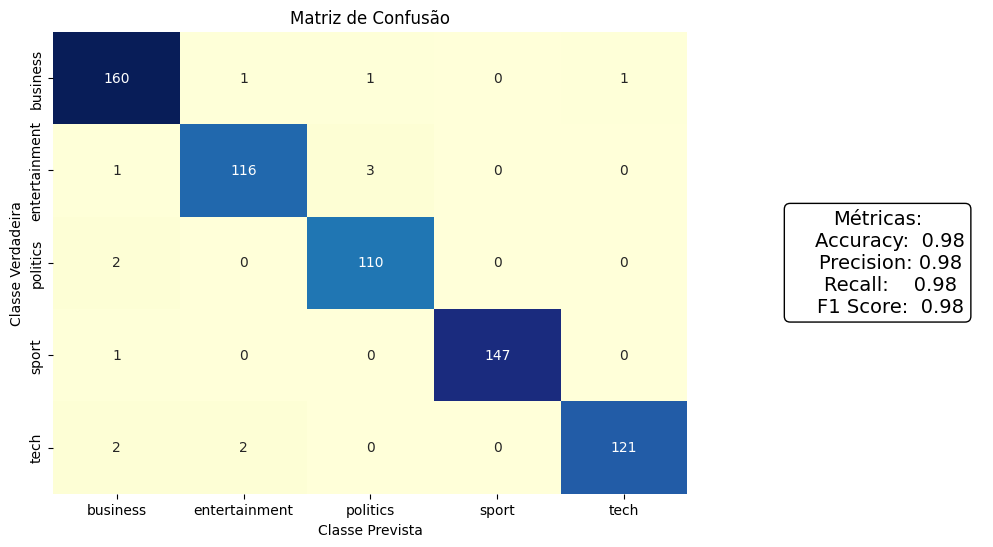

In [14]:
clf.fit(tfidf_df, y_train)
metrics_describe(clf, tfidf_df_test)

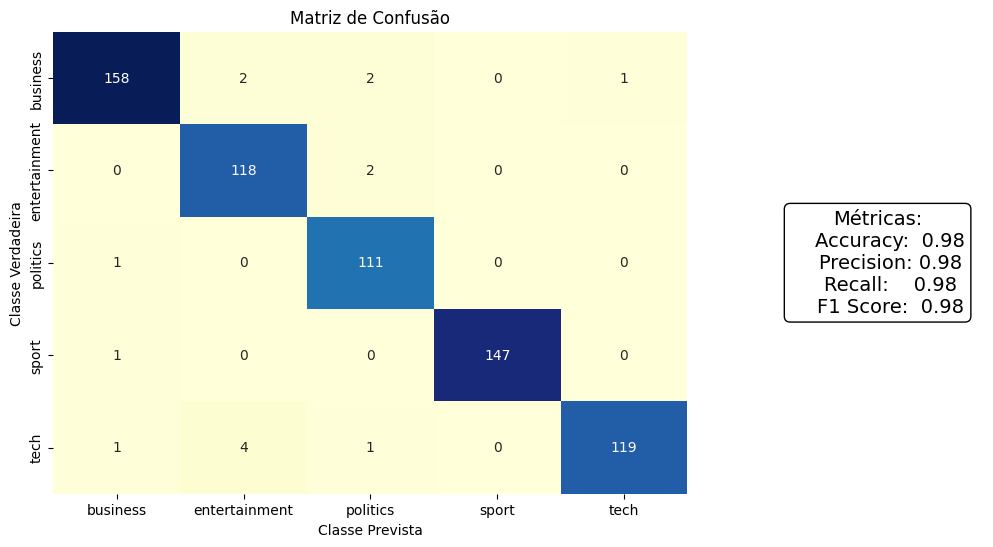

In [15]:
svm.fit(tfidf_df, y_train)
metrics_describe(svm, tfidf_df_test)

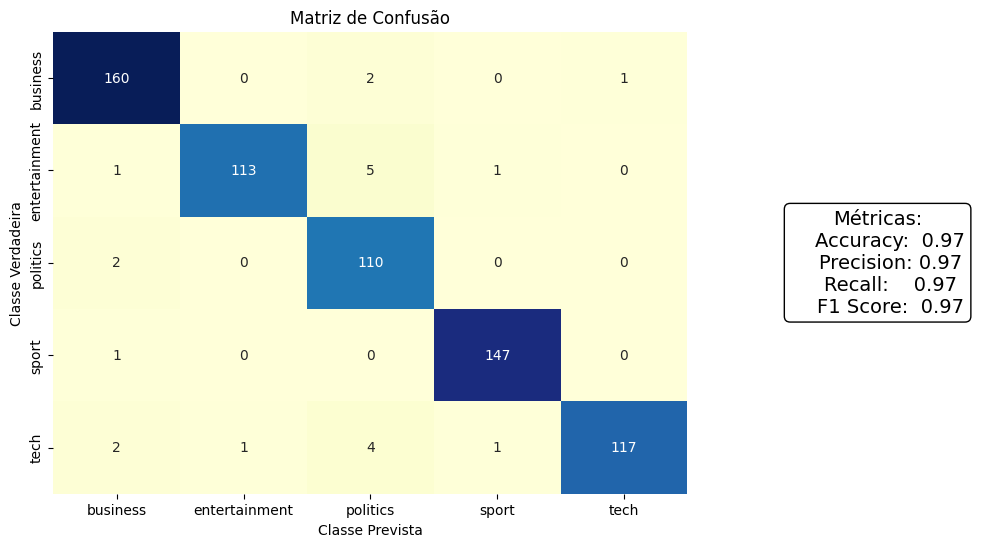

In [16]:
nb.fit(tfidf_df, y_train)
metrics_describe(nb, tfidf_df_test)

### Tem nem o que comparar !

# Modelagem de topicos com LDA, SVD e NMF

### LDA 

    Em resumo para construir nosso modelo precisamos definir o numero de topicos, k, e para isso avariaremos a perplexidade de k pertencente ao conjunto {2,..,10}.

In [17]:
# Criar o Dicionário do Gensim
id2word = corpora.Dictionary(texts_topics)

# Criar o corpus
corpus = [id2word.doc2bow(text) for text in texts_topics]

# Sample
print(corpus[222], "\n")
# Sample readable
print([[(id2word[id], freq) for id, freq in cp] for cp in corpus[:222]])

[(11, 1), (14, 1), (18, 1), (22, 1), (46, 1), (66, 5), (86, 2), (90, 1), (96, 2), (117, 4), (142, 1), (149, 1), (151, 1), (152, 1), (160, 2), (174, 3), (181, 1), (187, 1), (194, 1), (201, 2), (203, 2), (216, 3), (235, 1), (240, 1), (283, 1), (379, 1), (390, 1), (398, 1), (420, 1), (458, 1), (489, 4), (542, 1), (587, 2), (595, 4), (597, 2), (609, 1), (622, 1), (642, 1), (662, 2), (663, 5), (704, 1), (717, 1), (721, 5), (752, 1), (761, 1), (769, 8), (779, 1), (784, 4), (798, 4), (802, 2), (804, 1), (808, 1), (820, 2), (851, 1), (895, 1), (900, 1), (933, 1), (1013, 1), (1075, 1), (1201, 1), (1245, 1), (1296, 1), (1371, 1), (1416, 1), (1441, 1), (1443, 1), (1449, 2), (1470, 1), (1493, 1), (1529, 1), (1553, 1), (1618, 1), (1639, 1), (1700, 1), (1742, 1), (1744, 1), (1747, 1), (1755, 2), (1857, 1), (1919, 1), (1974, 1), (2053, 1), (2062, 1), (2082, 1), (2085, 2), (2106, 2), (2125, 4), (2127, 3), (2137, 1), (2155, 1), (2187, 1), (2215, 1), (2311, 2), (2316, 1), (2384, 1), (2397, 2), (2409, 1)

In [32]:
# Build LDA model
def computer_coherence(mode_type, corpus, id2word, texts = None, list_k = [2, 3, 4, 5, 6, 7, 8, 9, 10]):
    
    model_classes = {
        'lda': LdaModel,
        'lsi': LsiModel,
        'nmf': Nmf
    }
    if mode_type not in model_classes:
        raise ValueError(f"Invalid model type: {mode_type}")
    
    coherences = []

    for k in list_k:
        model_class = model_classes[mode_type]

        # Criando o modelo
        if mode_type == 'lda':
            model = LdaModel(corpus=corpus,id2word=id2word,num_topics=k,random_state=100,
                                            update_every=1,chunksize=100,passes=10,alpha='auto',per_word_topics=True)
        else:
            model = model_class(corpus=corpus,id2word=id2word,num_topics=k)

        # Calculando a coerência  
        coherence_model_lda=CoherenceModel(model=model,texts=texts,dictionary=id2word,coherence='c_v')
        coherences.append(coherence_model_lda.get_coherence())
    
    # Plotagem
    plt.plot(list_k, coherences)
    plt.xlabel("k")
    plt.ylabel("C_V")
    plt.legend(("C_V"), loc='best')
    plt.show()


pyLDAvis.enable_notebook()
vis=pyLDAvis.gensim.prepare(lda_model,corpus,id2word)
vis

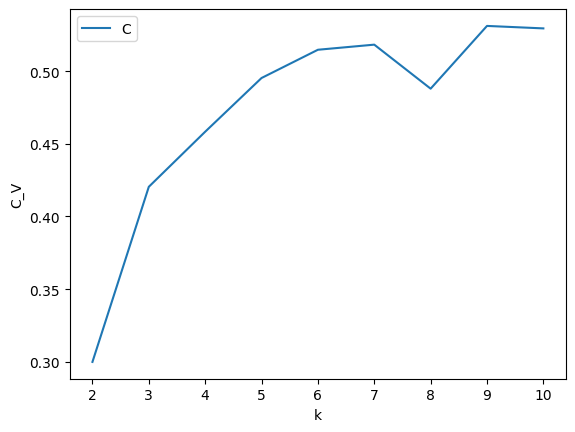

In [28]:
# Coerencia LDA
computer_coherence("lda", corpus=corpus, id2word=id2word, texts=texts_topics)


  Ao analizar o grafico de  correlação semantica entre os topicos, quanto maior a correlação mais proximos são os textos do topico, notemos que os ganhos de correlação, aparti de k=5 deixão de serem expressivos, o que nos leva a concluir que k=5 é um otimo valor para se trabalhar!

In [20]:
# Analize graficas dos topicos 
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=5, random_state=100, update_every=1,chunksize=100, passes=10, alpha='auto',per_word_topics=True)


/home/shinigami/.cache/pypoetry/virtualenvs/pln-LPbjoYHC-py3.12/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=188137) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/home/shinigami/.cache/pypoetry/virtualenvs/pln-LPbjoYHC-py3.12/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=188137) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/home/shinigami/.cache/pypoetry/virtualenvs/pln-LPbjoYHC-py3.12/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=188137) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/home/shinigami/.cache/pypoetry/virtualenvs/pln-LPbjoYHC-py3.12/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=188

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.018171 -0.019358       1        1  27.369178
0     -0.008436 -0.221591       2        1  21.090676
1     -0.215539  0.041401       3        1  20.454859
3      0.201281  0.033053       4        1  15.645763
2      0.004523  0.166495       5        1  15.439523, topic_info=        Term         Freq        Total Category  logprob  loglift
86        mr  2161.000000  2161.000000  Default  30.0000  30.0000
552     game  1069.000000  1069.000000  Default  29.0000  29.0000
784    music   508.000000   508.000000  Default  28.0000  28.0000
1538    firm   660.000000   660.000000  Default  27.0000  27.0000
96    people  1498.000000  1498.000000  Default  26.0000  26.0000
...      ...          ...          ...      ...      ...      ...
58     first   178.602480   913.872654   Topic5  -5.6929   0.2357
176    could   177.329415   936.970887   Topic5  -5.7000   0.2036
236    world   173.448865   918.000080   Topic5  -5.7222   0.2019
881     home   163.855767   580.845648   Topic5  -5.7790   0.6027
62       get   157.564036   630.221303   Topic5  -5.8182   0.4820

[334 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
825       1  0.147533   access
825       4  0.849788   access
3121      2  0.998069    actor
1365      2  0.997863  actress
2900      2  0.995105  airline
...     ...       ...      ...
152       3  0.219684     year
152       4  0.061076     year
152       5  0.100373     year
6979      4  0.996503    yukos
715       3  0.995979  zealand

[526 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 2, 4, 3])

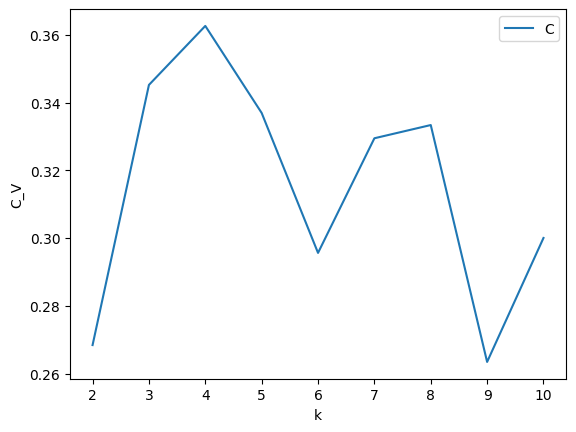

In [29]:
# Coerencia NMF
computer_coherence("nmf", corpus=corpus, id2word=id2word, texts=texts_topics)

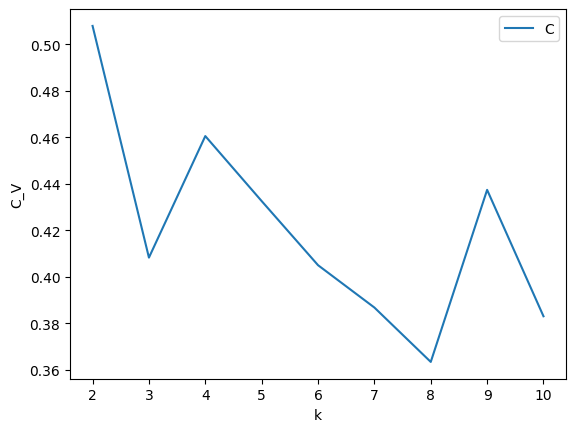

In [34]:
computer_coherence("lsi", corpus=corpus, id2word=id2word, texts=texts_topics)

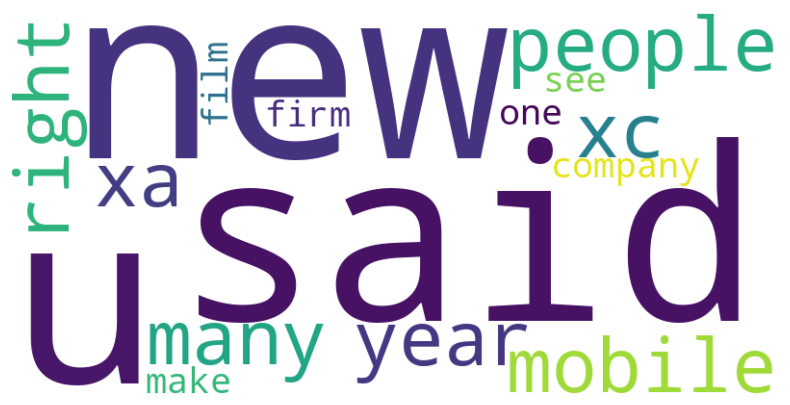

In [38]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt


nmf_model = Nmf(corpus=corpus, id2word=id2word, num_topics=5)
# Exemplo para NMF
topic_idx = 0  # Índice do tópico que você quer visualizar
topic_terms = nmf_model.get_topic_terms(topic_idx, topn=20)  # Obter as 20 principais palavras para o tópico

# Convertendo os IDs das palavras para as palavras reais
words = [id2word[term_id] for term_id, _ in topic_terms]

# Criar a nuvem de palavras
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(' '.join(words))

# Mostrar a nuvem de palavras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()